In [1]:
%load_ext tensorboard
import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers

import tensorflow_datasets as tfds

from utils import display_dataset, predict_tf

In [2]:
INPUT_SHAPE = (256, 512, 3)
NUM_CLASSES = 2
SCALE = 8

In [ ]:
from model import bisenetv2_compiled, bisenetv2_output_shape

OUTPUT_SHAPE = bisenetv2_output_shape(NUM_CLASSES, SCALE, input_shape=INPUT_SHAPE)
m = bisenetv2_compiled(num_classes=NUM_CLASSES, out_scale=SCALE, input_shape=INPUT_SHAPE)

In [ ]:
m.summary()

In [5]:
#tf.keras.utils.plot_model(m, show_shapes=True)

In [6]:
cityscapes = tfds.load('cityscapes/semantic_segmentation')

In [7]:
from data_prep import cityscapes_prep, class_map_road
from utils import segmentation_to_image

train_ds = cityscapes['train'].map(cityscapes_prep(OUTPUT_SHAPE, INPUT_SHAPE, class_map_road))
valid_ds = cityscapes['validation'].map(cityscapes_prep(OUTPUT_SHAPE, INPUT_SHAPE, class_map_road))

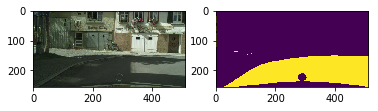

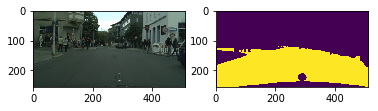

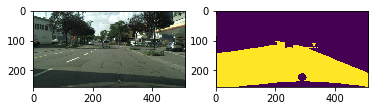

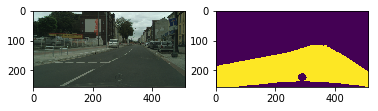

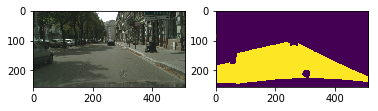

In [8]:
display_dataset(train_ds.take(5), lambda s: (s[0], s[1]))

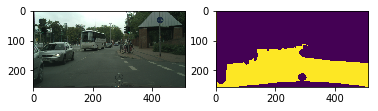

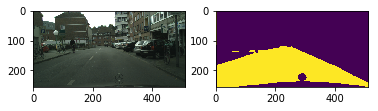

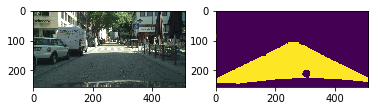

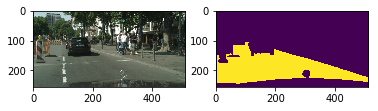

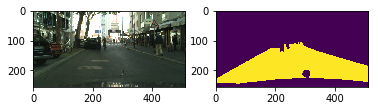

In [9]:
BATCH_SIZE = 4

USE_TINYCAR_DATA = False

if USE_TINYCAR_DATA:
    from data_prep import labelme_prep, uwula_prep

    ds = tf.data.Dataset.list_files('../paperstreet/1/*.json')
    ds = ds.map(labelme_prep(OUTPUT_SHAPE, INPUT_SHAPE))


    ds2 = tf.data.Dataset.list_files('/media/mldata/tinycar/Mikrowunderland_1k/*.jpg')
    ds2 = ds2.map(uwula_prep(OUTPUT_SHAPE, INPUT_SHAPE))

    ds = ds.concatenate(ds2)
    ds = ds.shuffle(1000)

    valid_ds = ds.take(24)
    train_ds = ds.skip(24)

train_ds = train_ds.batch(BATCH_SIZE).prefetch(100)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(100)


display_dataset(valid_ds.unbatch().take(5), lambda s: (s[0], s[1]))

In [11]:
EPOCHS = 10

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = m.fit(train_ds,
                validation_data=valid_ds,
                epochs=EPOCHS,
                callbacks=[tensorboard_callback])

Epoch 1/10
270/270 [==============================] - 155s 503ms/step - loss: 0.2303 - accuracy: 0.8989 - argmax_mean_iou: 0.7643 - val_loss: 0.3279 - val_accuracy: 0.9091 - val_argmax_mean_iou: 0.7493
Epoch 2/10
270/270 [==============================] - 146s 495ms/step - loss: 0.0668 - accuracy: 0.9762 - argmax_mean_iou: 0.9284 - val_loss: 0.1269 - val_accuracy: 0.9472 - val_argmax_mean_iou: 0.8583
Epoch 3/10
270/270 [==============================] - 147s 498ms/step - loss: 0.0550 - accuracy: 0.9796 - argmax_mean_iou: 0.9371 - val_loss: 0.0605 - val_accuracy: 0.9789 - val_argmax_mean_iou: 0.9344
Epoch 4/10
270/270 [==============================] - 147s 500ms/step - loss: 0.0405 - accuracy: 0.9859 - argmax_mean_iou: 0.9561 - val_loss: 0.0191 - val_accuracy: 0.9931 - val_argmax_mean_iou: 0.9791
Epoch 5/10
270/270 [==============================] - 147s 498ms/step - loss: 0.0296 - accuracy: 0.9893 - argmax_mean_iou: 0.9661 - val_loss: 0.2642 - val_accuracy: 0.9119 - val_argmax_mean_io

In [14]:
#m.save('model.tf')
m.save('model_untrained.tf')

INFO:tensorflow:Assets written to: model_untrained.tf/assets


In [12]:
test_ds = cityscapes['test'].map(cityscapes_prep(OUTPUT_SHAPE, INPUT_SHAPE, class_map_road))

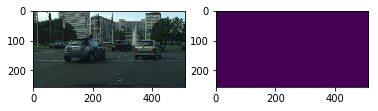

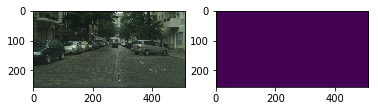

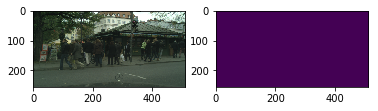

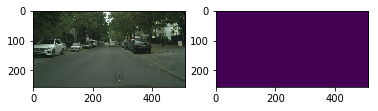

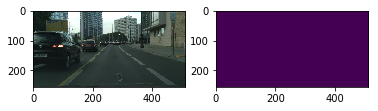

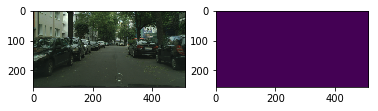

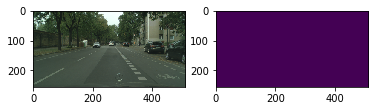

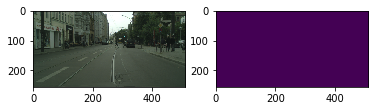

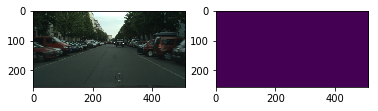

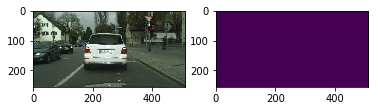

In [13]:
display_dataset(test_ds.take(10), predict_tf(m))
#display_dataset(valid_ds.unbatch().take(20), predict_tf(m))